In [1]:
%cd ..

/nfs/team205/ml19/projects/dis2p/scfair


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

In [4]:
import dis2p.dis2pvae as dvae
import dis2p.dis2pvi as dvi

[2023-11-10 08:46:24,709] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 0


In [5]:
import scvi
import scanpy as sc
import pandas as pd
from datetime import datetime

def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats
    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

adata = sc.read('data/kang_preprocessed2000.h5ad')

# specify name of dataset
data_name = 'Kang'

# specify attributes
cats = ['label', 'cell_type']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [6]:
# train params
epochs = 400
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

dvi.Dis2pVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
model = dvi.Dis2pVI(adata, n_layers=n_layers)
model.train(**train_dict)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB MIG 1c.3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/2/0]
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/

Epoch 64/400:  16%|█▌        | 64/400 [07:43<40:31,  7.24s/it, v_num=1, loss_validation=1.41e+3, x_0_validation=299, x_1_validation=303, x_2_validation=307, rec_x_cf_validation=417, z_1_validation=15.3, z_2_validation=15, ce_validation=0.794, acc_validation=1, f1_validation=1, adv_ce_validation=1.24, adv_acc_validation=0.509, adv_f1_validation=0.509, loss_train=1.35e+3, x_0_train=290, x_1_train=295, x_2_train=296, rec_x_cf_train=405, z_1_train=16.8, z_2_train=16.5, ce_train=0.794, acc_train=1, f1_train=1, adv_ce_train=1.05, adv_acc_train=0.497, adv_f1_train=0.497]  
Monitored metric loss_validation did not improve in the last 45 records. Best score: 1405.667. Signaling Trainer to stop.


In [7]:
model.save(f"{pre_path}/{model_name}")

In [10]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,Kang,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = dvi.Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

INFO     File                                                                                                      
         models/dis2p/2023-11-10,dis2p,Kang,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_weight=
         50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                      


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [11]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

---UMAP for dis2p_Z_0---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


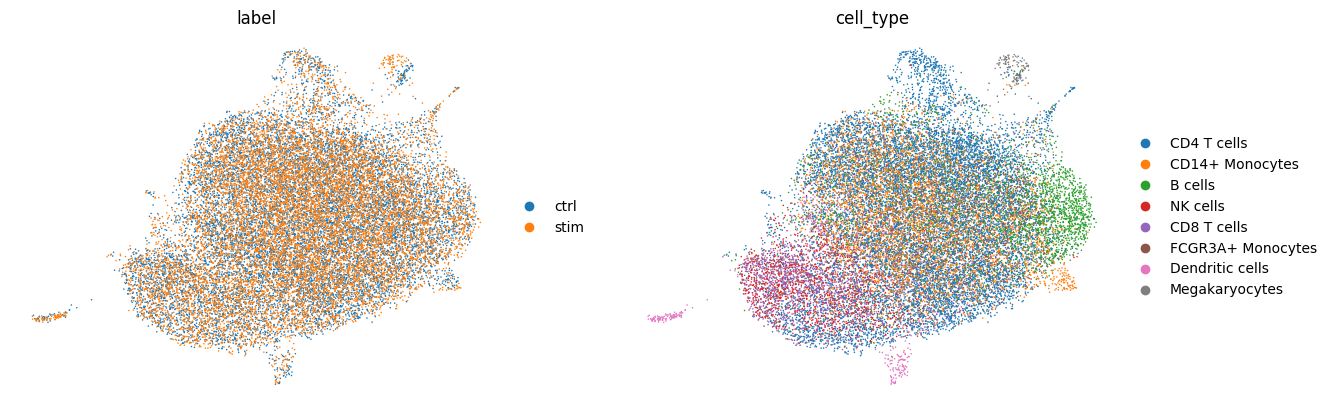

---UMAP for dis2p_Z_1---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


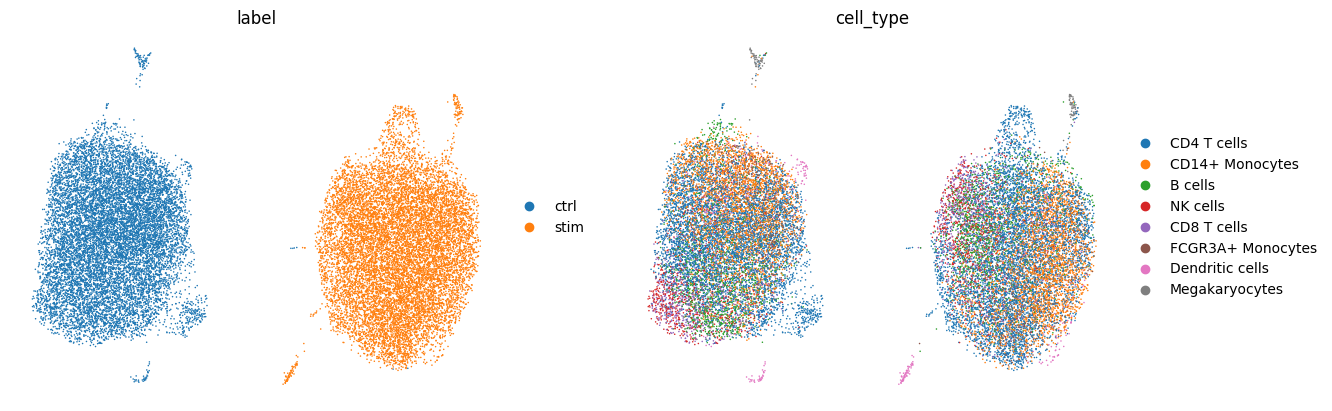

---UMAP for dis2p_Z_2---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


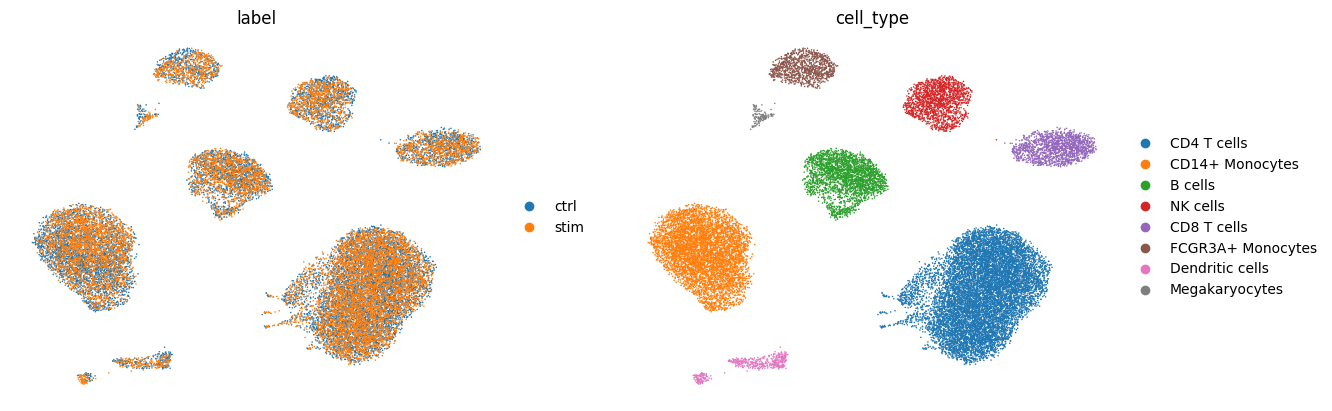

In [12]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )